In [20]:
import os
import gym
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import count
from PIL import Image
import os
import time

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

In [21]:
import os
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY")) == 0:
    !bash ../xvfb start
    %env DISPLAY = : 1

In [22]:
Transition = namedtuple('Transition',
                        ('state', 'action'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, *args):
        """Saves a transition."""
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [23]:
def select_elites(states_batch, actions_batch, rewards_batch, percentile=50):
    """
    Select states and actions from games that have rewards >= percentile
    :param states_batch: list of lists of states, states_batch[session_i][t]
    :param actions_batch: list of lists of actions, actions_batch[session_i][t]
    :param rewards_batch: list of rewards, rewards_batch[session_i][t]

    :returns: elite_states,elite_actions, both 1D lists of states and respective actions from elite sessions

    Please return elite states and actions in their original order 
    [i.e. sorted by session number and timestep within session]

    If you're confused, see examples below. Please don't assume that states are integers (they'll get different later).
    """

    reward_threshold = np.percentile(rewards_batch, percentile)
    
    elite_states  = [s for i in range(len(states_batch)) if rewards_batch[i]>=reward_threshold for s in states_batch[i]]
    elite_actions = [a for i in range(len(actions_batch)) if rewards_batch[i]>=reward_threshold for a in actions_batch[i]]
    
    return elite_states, elite_actions

In [24]:
from IPython.display import clear_output
def show_progress(rewards_batch, log,running_loss,reward_range=[-990, +10]):
    """
    A convenience function that displays training progress. 
    No cool math here, just charts.
    """
    mean_reward = np.mean(rewards_batch)
    threshold = np.percentile(rewards_batch, percentile)
    log.append([mean_reward, threshold, running_loss])

    clear_output(True)
    print("mean reward = %.3f, threshold=%.3f" % (mean_reward, threshold))
    plt.figure(figsize=[8, 4])
    plt.subplot(1, 2, 1)
    plt.plot(list(zip(*log))[0], label='Mean rewards')
    plt.plot(list(zip(*log))[1], label='Reward thresholds')
    plt.legend()
    plt.grid()

    print('loss', running_loss)
    plt.figure(figsize=[8, 4])
    plt.subplot(1, 2, 1)
    plt.plot(list(zip(*log))[2], label='loss')
    plt.legend()
    plt.grid()

    plt.show()

In [25]:
env = gym.make("LunarLander-v2").env
env.reset()
n_actions = env.action_space.n

In [26]:
resize = T.Compose([T.ToPILImage(),
                    T.Grayscale(),
                    T.Resize(( 84,84 ), interpolation=Image.BICUBIC),
                    T.ToTensor() ])
def get_screen():
    screen = env.render(mode='rgb_array')
    screen = resize(screen)
    return screen

In [160]:
# class SimpleConvNet(nn.Module):
#     def __init__(self):
#         super(SimpleConvNet, self).__init__()
        
#         self.conv1 = nn.Conv2d(1, 8, 8)
#         self.conv2 = nn.Conv2d(8,16, 4)
#         self.conv3 = nn.Conv2d(16, 16, 3)
        
#         self.fc1 = nn.Linear(87616, 64)
#         self.fc2 = nn.Linear(64, 4)

#     def forward(self, x):
#         x = F.relu(self.conv1(x))
#         x = F.relu(self.conv2(x))
#         # print(x.shape)
#         x = x.view(-1, 87616)
#         x = F.relu(self.fc1(x))
#         x = self.fc2(x)
#         return x

class DQN(nn.Module):

    def __init__(self):
        super(DQN, self).__init__()  
        self.fc1 = nn.Linear(8, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc_out = nn.Linear(32, 4)

    def forward(self, x):
        out = F.relu(self.fc1(x))
        out = F.relu(self.fc2(out))
        out = F.relu(self.fc3(out))
        action = self.fc_out(out)
        
        return action

In [167]:
# объявляем сеть
net = DQN()

# выбираем функцию потерь
loss_fn = torch.nn.CrossEntropyLoss()

# выбираем алгоритм оптимизации и learning_rate
learning_rate = 1e-4
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

memory = ReplayMemory(100)

In [168]:
def generate_session(t_max=1000):

    states, actions = [], []
    total_reward = 0

    
    s = torch.Tensor(env.reset())

    for t in range(t_max):
        
        a = net(s)
        
        _, predicted = torch.max(a.view(1,-1), 1)
        
        a = predicted.item()
        
        new_s, r, done, _ = env.step(a)

        states.append(s)
        actions.append(torch.Tensor([int(a)]))
        total_reward += r
        
        s = torch.Tensor(new_s)
        
        if done:
            break
            
    return states, actions, total_reward

In [169]:
from tqdm import tqdm_notebook

mean reward = -893.821, threshold=-559.336
loss 3910.2759353758365


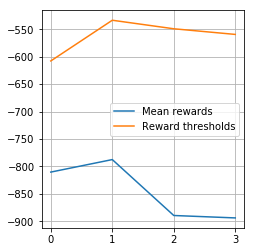

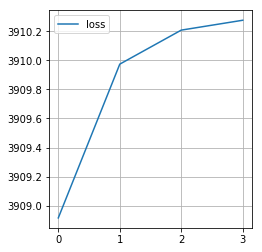

KeyboardInterrupt: 

In [172]:
n_sessions = 50
percentile = 70
log = []
BATCH_SIZE = 16

for i in tqdm_notebook(range(100)):
    
    sessions = [generate_session() for _ in tqdm_notebook(range(n_sessions))]
    states_batch, actions_batch, rewards_batch = map(np.array, zip(*sessions))
    elite_states, elite_actions = select_elites(states_batch, actions_batch, rewards_batch, percentile)
    
    
    for state, action in zip(elite_states, elite_actions):
        
        X_batch, y_batch =  state , action
        
        y_batch = int(y_batch.item())
    
        optimizer.zero_grad()
        y_pred = net(X_batch)
      
        
        loss = loss_fn(y_pred.view(1,-1), torch.LongTensor([y_batch]) )
        loss.backward()
        optimizer.step()

        # выведем текущий loss
        running_loss += loss.item()
        
    show_progress(rewards_batch, log, running_loss, reward_range=[0, np.max(rewards_batch)])

    if np.mean(rewards_batch) > 190:
        print('epoch', i)
        print("You Win! You may stop training now via KeyboardInterrupt.")

In [1]:
import random

In [8]:
noise = [random.uniform(-0.1,0.1) for _ in range(4)]

In [9]:
noise 

[0.0011116638318947186,
 -0.02569410000950692,
 0.05244498337711426,
 0.04567922413935538]